Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts.clean import clean_dataset
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

## Load Dataset

In [2]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = clean_dataset(X, "adult")

age = [val.left for val in df.age.unique()]
age.sort()

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


## Model training and test

In [3]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

Wall time: 7.67 s


array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.])

In [5]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     10205
           1       0.73      0.60      0.66      3362

    accuracy                           0.84     13567
   macro avg       0.80      0.76      0.78     13567
weighted avg       0.84      0.84      0.84     13567



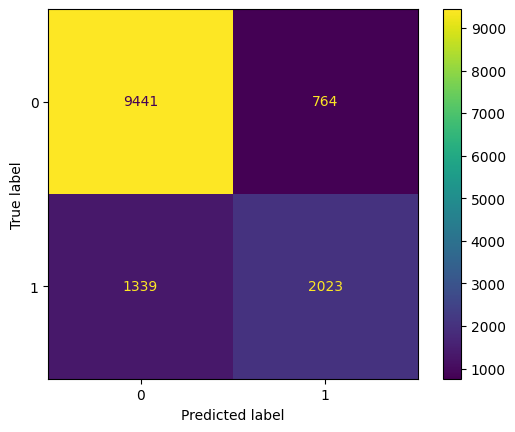

In [6]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [13]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='sex',
    freqitem_minsupp = 0.04,
    missing_subgroup_val="Unknown",
    drop_infeasible = True,
    drop_above = True
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████| 4724/4724 [00:00<00:00, 348486.41it/s]


Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|██████████| 2274/2274 [00:00<00:00, 10532.71it/s]

Computing correctenesses for all valid if-thens.



100%|██████████| 5140/5140 [06:41<00:00, 12.82it/s]


Number of if-thens: 5140


In [7]:
### Uncomment if you wish to load rules object from disk that haven't be computed with drop_infeasible = True,drop_above = True

import dill

with open("rulesAdultFairTest_preproc.data", "rb") as inf:
    rules_by_if = dill.load(inf)

In [25]:
### Uncomment if you wish to save rules object on disk

import dill

with open("rulesAdultFairTest_preproc.data", "wb") as outf:
    dill.dump(rules_by_if, outf)

In [9]:
# run this section if you load data from disk 

from gfacts.predicate import drop_two_above
ifthens = gfacts.rulesbyif2rules(rules_by_if)
ifthens = [(ifs,then,cov,cor) for ifs,then,cov,cor in ifthens if gfacts.recIsValid(ifs,then,X_test,True)]
ifthens = [(ifs,then,cov,cor) for ifs,then,cov,cor in ifthens if drop_two_above(ifs,then,age)]
rules_by_if = gfacts.rules2rulesbyif(ifthens)

In [14]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1][" Male"][1][0][1]-e[1][" Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If capital-gain = 0, hours-per-week = FullTime, occupation =  Other-service:
	Protected Subgroup ' Female', 6.60% covered
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 3.72%.
		Make occupation =  Exec-managerial with correctness 2.60%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 3.35%.
		Make occupation =  Prof-specialty with correctness 0.74%.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 0.74%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 3.35%.
	Protected Subgroup ' Male', 4.31% covered
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 23.88%.
		Make occupation =  Exec-managerial with correctness 10.03%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 15.22%.
		Make occupation =  Prof-specialty with correctness 8.30%.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 8

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [15]:
feature_weights = {"sex": 1, "age": 1, "relationship": 10, "education-num": 20}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = gfacts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    feature_weights=feature_weights,
    num_normalization=True
)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [16]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 500,
    filter_sequence = [
        "remove-contained",
        # "remove-below-thr",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    cor_threshold=None,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If capital-gain = 0, capital-loss = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 70.03% covered out of 4077
		Make capital-gain = 15024 with correctness 69.95%.
		Aggregate cost of the above recourses = -4.66
	Protected Subgroup ' Male', 75.73% covered out of 6703
		Make capital-gain = 15024 with correctness 81.88%.
		Aggregate cost of the above recourses = -5.45
	Bias against  Female. Unfairness measure = 0.79.
If capital-gain = 0, capital-loss = 0, native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 10.87% covered out of 4077
		Make occupation =  Exec-managerial with correctness 1.81%.
		Make occupation =  Prof-specialty with correctness 0.45%.
		Aggregate cost of the above recourses = -0.01
	Protected Subgroup ' Male', 8.13% covered out of 6703
		Make occupation =  Exec-managerial with correctness 21.28%.
		Make occupation =  Prof-specialty with correctness 14.13%.
		Aggregate cost of the above reco

## Minimum cost above threshold

In [23]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=100,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",        
        "remove-fair-rules",
        # "keep-only-min-change"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        "max-group-corr"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If education-num = 13, marital-status =  Never-married:
	Protected Subgroup ' Female', 8.31% covered out of 4077
		Make education-num = 15, marital-status =  Married-civ-spouse with correctness 23.60%.
		Aggregate cost of the above recourses = 3.67
	Protected Subgroup ' Male', 5.45% covered out of 6703
		Make education-num = 14, marital-status =  Married-civ-spouse with correctness 24.38%.
		Make education-num = 15, marital-status =  Married-civ-spouse with correctness 34.52%.
		Aggregate cost of the above recourses = 2.33
	Bias against  Female. Unfairness measure = 1.33.
If Workclass =  Private, hours-per-week = FullTime, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Female', 7.82% covered out of 4077
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 33.23%.
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 23.82%.
		Make hours-per-week = BrainDrai

## Mean cost above threshold

In [24]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=100,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        "remove-fair-rules",
        # "keep-only-min-change"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If capital-gain = 0, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Female', 12.85% covered out of 4077
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' Male', 8.86% covered out of 6703
		Make occupation =  Exec-managerial with correctness 20.20%.
		Aggregate cost of the above recourses = 1.00
	Bias against  Female. Unfairness measure = inf.
If occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 11.80% covered out of 4077
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' Male', 8.82% covered out of 6703
		Make occupation =  Exec-managerial with correctness 20.64%.
		Aggregate cost of the above recourses = 1.00
	Bias against  Female. Unfairness measure = inf.
If age = (26.0, 34.0], marital-status =  Never-married, native-country =  United-States:
	Protected Subgroup ' Female', 9.66% covered out of 4077
		Make age = (41.0, 50.0], marital-sta

## Number above threshold

In [25]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=10,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If Workclass =  Private, marital-status =  Divorced, relationship =  Not-in-family:
	Protected Subgroup ' Female', 8.44% covered out of 4077
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 27.62%.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 31.10%.
		Make Workclass =  Federal-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 39.53%.
		Aggregate cost of the above recourses = -3.00
	Protected Subgroup ' Male', 5.58% covered out of 6703
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 29.95%.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 31.82%.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 24.06%.
		Make Workclass =  Federal-gov, marital-status =  Married-civ-spouse, relationship =  M

# Aggregate correctness of rules and cost correctness plots

Load state from disk, if you wish.

In [ ]:
import dill

with open("stateAdultFairTest.data", "rb") as inf:
    rules_by_if, model, X_test = dill.load(inf)

FileNotFoundError: [Errno 2] No such file or directory: 'stateAdultFairTest.data'

If Workclass =  Private, marital-status =  Divorced, relationship =  Not-in-family:
	Protected Subgroup ' Female', 8.44% covered out of 14695
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 27.62%.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 31.10%.
		Make Workclass =  Federal-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 39.53%.
	Protected Subgroup ' Male', 5.58% covered out of 30527
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 29.95%.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 31.82%.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 24.06%.
		Make Workclass =  Federal-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 44.12%.
		Make Workcla

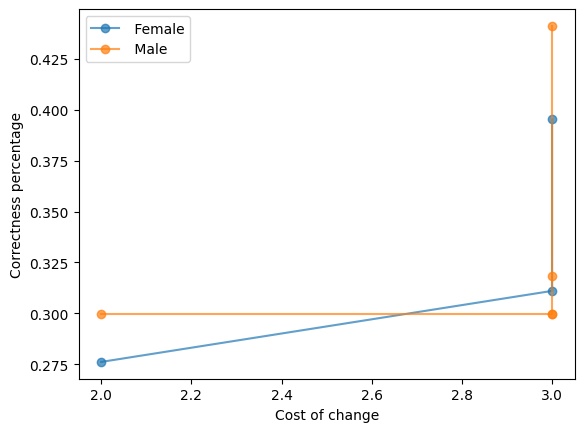

If hours-per-week = FullTime, occupation =  Other-service:
	Protected Subgroup ' Female', 6.72% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 4.42% covered out of 30527
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 24.66%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 22.97%.
	Bias against  Female. Unfairness measure = 2.
	Cumulative correctness plot for the above recourses:


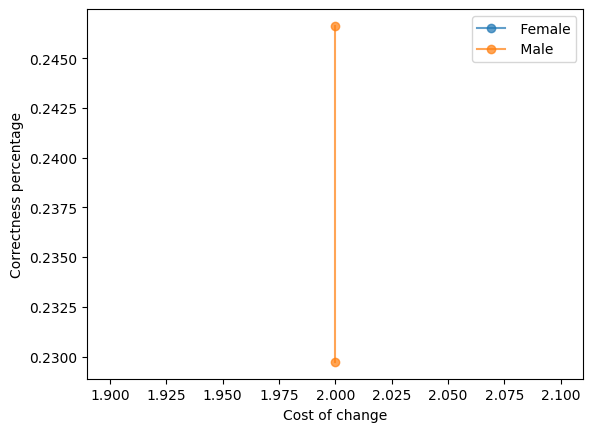

If capital-loss = 0, hours-per-week = FullTime, occupation =  Other-service:
	Protected Subgroup ' Female', 6.62% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 4.27% covered out of 30527
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 24.13%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 22.38%.
	Bias against  Female. Unfairness measure = 2.
	Cumulative correctness plot for the above recourses:


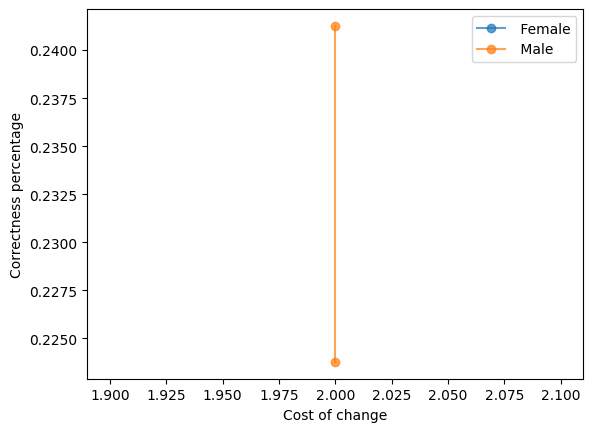

If capital-gain = 0, hours-per-week = FullTime, occupation =  Other-service:
	Protected Subgroup ' Female', 6.60% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 4.31% covered out of 30527
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 23.88%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 22.15%.
	Bias against  Female. Unfairness measure = 2.
	Cumulative correctness plot for the above recourses:


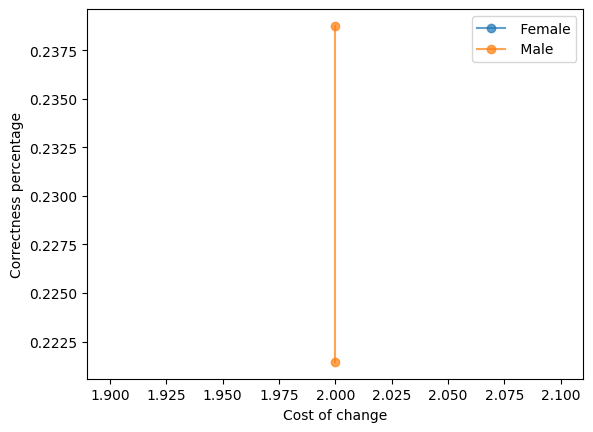

If age = (26.0, 34.0], capital-loss = 0, hours-per-week = FullTime, marital-status =  Never-married:
	Protected Subgroup ' Female', 5.89% covered out of 14695
		Make age = (41.0, 50.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse with correctness 26.25%.
		Make age = (41.0, 50.0], hours-per-week = BrainDrain, marital-status =  Married-civ-spouse with correctness 26.25%.
	Protected Subgroup ' Male', 4.68% covered out of 30527
		No recourses for this subgroup!
	Bias against  Male. Unfairness measure = 2.
	Cumulative correctness plot for the above recourses:


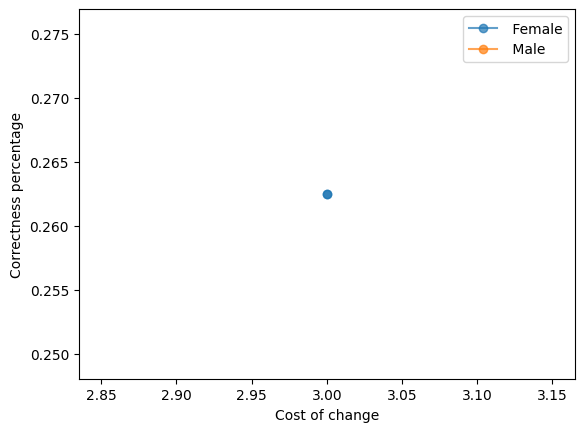

If age = (26.0, 34.0], capital-gain = 0, hours-per-week = FullTime, marital-status =  Never-married:
	Protected Subgroup ' Female', 5.86% covered out of 14695
		Make age = (41.0, 50.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse with correctness 25.94%.
		Make age = (41.0, 50.0], hours-per-week = BrainDrain, marital-status =  Married-civ-spouse with correctness 25.94%.
	Protected Subgroup ' Male', 4.68% covered out of 30527
		No recourses for this subgroup!
	Bias against  Male. Unfairness measure = 2.
	Cumulative correctness plot for the above recourses:


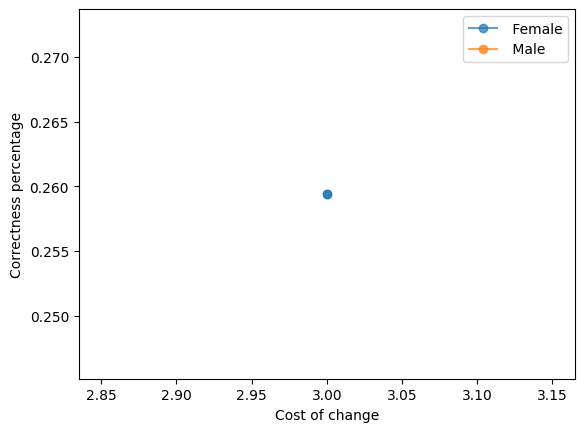

If age = (26.0, 34.0], capital-loss = 0, hours-per-week = FullTime, marital-status =  Never-married, native-country =  United-States:
	Protected Subgroup ' Female', 5.32% covered out of 14695
		Make age = (41.0, 50.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse with correctness 28.11%.
		Make age = (34.0, 41.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse with correctness 20.28%.
		Make age = (41.0, 50.0], hours-per-week = BrainDrain, marital-status =  Married-civ-spouse with correctness 28.11%.
	Protected Subgroup ' Male', 4.06% covered out of 30527
		Make age = (41.0, 50.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse with correctness 20.22%.
	Bias against  Male. Unfairness measure = 2.
	Cumulative correctness plot for the above recourses:


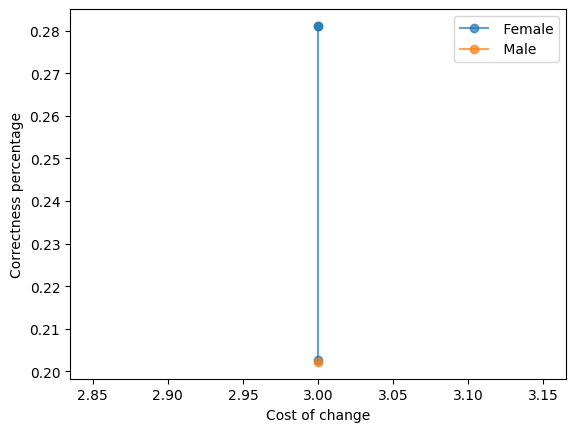

If hours-per-week = OverTime, marital-status =  Never-married, race =  White:
	Protected Subgroup ' Female', 4.27% covered out of 14695
		Make marital-status =  Married-civ-spouse with correctness 23.56%.
		Make hours-per-week = BrainDrain, marital-status =  Married-civ-spouse with correctness 20.11%.
	Protected Subgroup ' Male', 5.95% covered out of 30527
		No recourses for this subgroup!
	Bias against  Male. Unfairness measure = 2.
	Cumulative correctness plot for the above recourses:


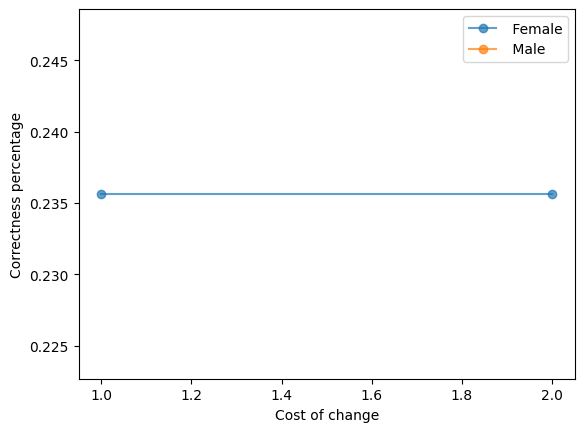

If Workclass =  Private, marital-status =  Never-married, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Female', 13.76% covered out of 14695
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 23.89%.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 25.13%.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 20.50%.
		Make Workclass =  Federal-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 32.62%.
	Protected Subgroup ' Male', 11.98% covered out of 30527
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 23.66%.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 25.03%.
		Make Workclass =  Federal-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 

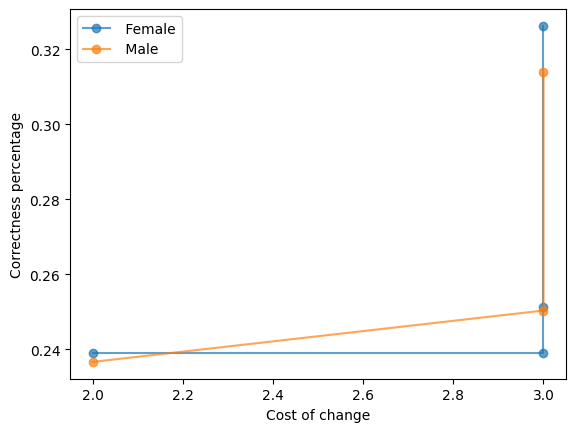

If Workclass =  Private, capital-gain = 0, capital-loss = 0, marital-status =  Never-married, native-country =  United-States, relationship =  Not-in-family:
	Protected Subgroup ' Female', 13.71% covered out of 14695
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 20.75%.
	Protected Subgroup ' Male', 11.38% covered out of 30527
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 20.05%.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 21.63%.
	Bias against  Female. Unfairness measure = 1.
	Cumulative correctness plot for the above recourses:


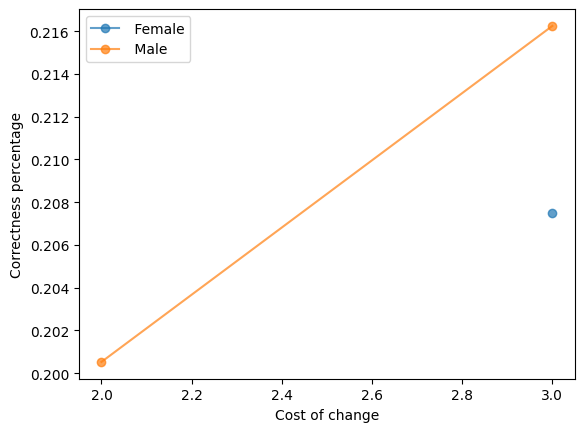

In [26]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.2,
    filter_sequence=["remove-below-thr"]
)

cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute="sex")

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [ ]:
import dill

with open("stateAdultFairTest.data", "wb") as outf:
    dill.dump((rules_by_if, model, X_test), outf)